<a href="https://colab.research.google.com/github/karasu1982/colab_notebook/blob/main/202510_CRM%E3%83%AA%E3%82%B9%E3%82%AF%E5%88%86%E6%9E%90_(QRCNN%2BLSTM%2BCross_Attention%2C_Quantile_Regression).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, io, math, random, urllib.request, zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
import kagglehub

# -------------------------------------------------------
# 1) データ取得
# UCI: Default of Credit Card Clients
# ソース: https://www.kaggle.com/datasets/pratjain/credit-card-default?select=credit_card_default_TRAIN.csv
# -------------------------------------------------------

path = kagglehub.dataset_download("pratjain/credit-card-default")
df = pd.read_csv(path + "/credit_card_default_TRAIN.csv")

# カラム名を手動で設定
new_columns = [
    'ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
    'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
    'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default payment next month'
]
df.columns = new_columns
df = df.drop(0).reset_index(drop=True)

# 数値データをINT型へ
columns_to_convert = [
    'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
    'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE' # Include these columns as they are likely causing issues as well
]

for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

display(df.head())

Using Colab cache for faster access to the 'credit-card-default' dataset.


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
# -------------------------------------------------------
# 2) 欠損・クリーニング（必要最低限）
# -------------------------------------------------------
df = df.dropna().copy()

# LIMIT_BAL > 0 のみ残す
df = df[df['LIMIT_BAL'] > 0].copy()

# 支払い/請求の負値は0に丸め（外れ値扱い簡略化）
bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]
pay_cols  = [f'PAY_AMT{i}'  for i in range(1, 7)]
for c in bill_cols + pay_cols:
    df[c] = df[c].clip(lower=0)

In [ ]:
# -------------------------------------------------------
# 3) 目的変数（翌月の未払い比率）を定義
#    unpaid_ratio_next = max(0, BILL_AMT1 - PAY_AMT1) / LIMIT_BAL
#    ※BILL_AMT1: 直近月の請求額, PAY_AMT1: 直近月の支払
# -------------------------------------------------------
df['unpaid_next'] = np.maximum(0.0, df['BILL_AMT1'] - df['PAY_AMT1']) / df['LIMIT_BAL']
# 上限クリップ（極端値で損失が暴れないように）
df['unpaid_next'] = df['unpaid_next'].clip(0, 5.0)

In [ ]:
# -------------------------------------------------------
# 4) 時系列特徴の構築
#   - 直近から遡る: 月1(直近) .. 月6(過去)
#   - 学習に使うシーケンスは「過去6ヶ月」= [BILL_AMT6..1, PAY_AMT6..1]のうち、
#     予測にリークを避けるため、ターゲット=unpaid_next(BILL1-PAY1) を使うなら
#     入力は「BILL_AMT6..2, PAY_AMT6..2」の5ヶ月 or 「BILL_AMT6..1, PAY_AMT6..1」の6ヶ月?
#   - ここでは targetがBILL1/PAY1で作られるため、入力は "過去6ヶ月の比率(2..6)" とし、
#     T=5 を採用。（リーク回避）
# -------------------------------------------------------
# 月2..6を過去（古→新の順）で並べる
T = 5
bill_seq = [f'BILL_AMT{i}' for i in range(6, 1, -1)]  # 6,5,4,3,2
pay_seq  = [f'PAY_AMT{i}'  for i in range(6, 1, -1)]  # 6,5,4,3,2

# 比率特徴を作成
for i in range(T):
    bcol, pcol = bill_seq[i], pay_seq[i]
    df[f'bill_ratio_t{i}'] = (df[bcol] / df['LIMIT_BAL']).clip(0, 5.0)
    df[f'pay_ratio_t{i}']  = (df[pcol]  / df['LIMIT_BAL']).clip(0, 5.0)
    df[f'unpaid_ratio_t{i}'] = np.maximum(0.0, df[bcol] - df[pcol]) / df['LIMIT_BAL']
    df[f'unpaid_ratio_t{i}'] = df[f'unpaid_ratio_t{i}'].clip(0, 5.0)

# シーケンスに使うチャネルは「[bill_ratio, pay_ratio, unpaid_ratio]」の3チャネル
seq_feat = []
for i in range(T):
    seq_feat += [f'bill_ratio_t{i}', f'pay_ratio_t{i}', f'unpaid_ratio_t{i}']
SEQ_CHANNELS = 3

# 静的特徴（最小限）
static_cols = [
    'LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE',
    'PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'
]

# 欠損/カテゴリ外れ値の簡易処理
for c in ['SEX','EDUCATION','MARRIAGE']:
    df[c] = df[c].fillna(df[c].mode().iloc[0]).astype(int)

X_seq_raw = df[seq_feat].values.reshape(-1, T, SEQ_CHANNELS)  # (N, T, C)
X_static_raw = df[static_cols].values
y_raw = df['unpaid_next'].values.astype('float32')

# スケーリング（静的は標準化、シーケンスはそのまま比率なので無スケール）
scaler_static = StandardScaler()
X_static = scaler_static.fit_transform(X_static_raw)
X_seq = X_seq_raw.astype('float32')

# 学習/検証/テスト分割
X_seq_train, X_seq_tmp, X_static_train, X_static_tmp, y_train, y_tmp = train_test_split(
    X_seq, X_static, y_raw, test_size=0.3, random_state=SEED
)
X_seq_val, X_seq_test, X_static_val, X_static_test, y_val, y_test = train_test_split(
    X_seq_tmp, X_static_tmp, y_tmp, test_size=0.5, random_state=SEED
)

print("Shapes:",
      X_seq_train.shape, X_static_train.shape, y_train.shape,
      "| val:", X_seq_val.shape, X_static_val.shape, y_val.shape,
      "| test:", X_seq_test.shape, X_static_test.shape, y_test.shape)

Shapes: (15749, 5, 3) (15749, 11) (15749,) | val: (3375, 5, 3) (3375, 11) (3375,) | test: (3375, 5, 3) (3375, 11) (3375,)


In [ ]:
# -------------------------------------------------------
# 5) カスタム Pinball (Quantile) Loss
#    複数分位同時学習: q_list = [0.1,0.5,0.9]
#    出力は次元=3、損失は平均
# -------------------------------------------------------
q_list = [0.1, 0.5, 0.9]
Q = len(q_list)

def multi_quantile_pinball(y_true, y_pred):
    # y_pred: (batch, Q)
    y_true = tf.expand_dims(y_true, axis=-1)       # (batch, 1)
    e = y_true - y_pred                             # (batch, Q)
    losses = []
    for i, q in enumerate(q_list):
        ei = e[:, i]
        loss_q = tf.maximum(q * ei, (q - 1) * ei)  # pinball
        losses.append(loss_q)
    return tf.reduce_mean(tf.add_n(losses) / Q)

In [ ]:
# -------------------------------------------------------
# 6) QRCNN + LSTM + Cross-Attention モデル
#   - Conv1Dで時系列の局所パターン抽出（QRCNNの近似）
#   - LSTMで長期依存
#   - 静的特徴をMLPで埋め込み
#   - Cross-Attention: Query=静的埋め込み（1トークン化）, Key/Value=時系列埋め込み
#   - 出力で3分位を同時に予測
# -------------------------------------------------------
def build_qrcnn_lstm_crossattn(
    T, C, static_dim, conv_filters=64, kernel_size=2,
    lstm_units=64, static_hidden=64, attn_heads=4, attn_key_dim=32, ff_hidden=128, Q=3
):
    # 時系列入力
    in_seq = layers.Input(shape=(T, C), name="seq")
    x = layers.Conv1D(conv_filters, kernel_size=kernel_size, padding="causal", activation="relu")(in_seq)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(conv_filters, kernel_size=kernel_size, padding="causal", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LSTM(lstm_units, return_sequences=True)(x)  # (B, T, lstm_units)

    # 静的入力
    in_static = layers.Input(shape=(static_dim,), name="static")
    s = layers.Dense(static_hidden, activation="relu")(in_static)
    s = layers.BatchNormalization()(s)
    # 1トークンにしてAttentionのQueryに使う
    s_token = layers.Reshape((1, static_hidden))(s)

    # Cross-Attention
    attn = layers.MultiHeadAttention(num_heads=attn_heads, key_dim=attn_key_dim)
    # Query = 静的(1, d), Key/Value = 時系列(T, d_k)
    # Key/Value次元合わせのために線形変換
    kv = layers.Dense(attn_heads * attn_key_dim, activation=None)(x)  # (B,T,H*D)
    kv = layers.Reshape((T, attn_heads * attn_key_dim))(kv)

    # MultiHeadAttention expects [B,T,d]; it will project internally; pass x directly
    cross = attn(query=s_token, value=x, key=x)  # (B, 1, d_v=lstm_units)

    # skip-connection: s_token と cross を結合
    fuse = layers.Concatenate(axis=-1)([s_token, cross])  # (B,1, static_hidden + lstm_units)
    fuse = layers.Flatten()(fuse)
    fuse = layers.Dense(ff_hidden, activation="relu")(fuse)
    fuse = layers.Dropout(0.2)(fuse)
    out = layers.Dense(Q, activation=None, name="quantiles")(fuse)

    model = Model(inputs=[in_seq, in_static], outputs=out, name="QRCNN_LSTM_CrossAttn")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=multi_quantile_pinball)
    return model

model = build_qrcnn_lstm_crossattn(
    T=T, C=SEQ_CHANNELS, static_dim=X_static_train.shape[1],
    conv_filters=64, kernel_size=2, lstm_units=64,
    static_hidden=64, attn_heads=4, attn_key_dim=32, ff_hidden=128, Q=Q
)
model.summary()

Model: "QRCNN_LSTM_CrossAttn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq (InputLayer)    │ (None, 5, 3)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 64)     │        448 │ seq[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static (InputLayer) │ (None, 11)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 5, 64)     │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        768 │ static[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5, 64)     │      8,256 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 64)     │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 64)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 5, 64)     │     33,024 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 64)     │     33,216 │ lstm[0][0],       │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0],    │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 128)    │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 128)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ quantiles (Dense)   │ (None, 3)         │        387 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,379 (364.76 KB)

 Trainable params: 92,995 (363.26 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# -------------------------------------------------------
# 7) 学習
# -------------------------------------------------------
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, verbose=1)
]
hist = model.fit(
    [X_seq_train, X_static_train], y_train,
    validation_data=([X_seq_val, X_static_val], y_val),
    epochs=40, batch_size=512, callbacks=callbacks, verbose=2
)

Epoch 1/40
31/31 - 7s - 213ms/step - loss: 0.1394 - val_loss: 0.1456 - learning_rate: 1.0000e-03
Epoch 2/40
31/31 - 2s - 68ms/step - loss: 0.0809 - val_loss: 0.1465 - learning_rate: 1.0000e-03
Epoch 3/40
31/31 - 2s - 60ms/step - loss: 0.0513 - val_loss: 0.1528 - learning_rate: 1.0000e-03
Epoch 4/40

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
31/31 - 3s - 82ms/step - loss: 0.0407 - val_loss: 0.1458 - learning_rate: 1.0000e-03
Epoch 5/40
31/31 - 3s - 110ms/step - loss: 0.0373 - val_loss: 0.1435 - learning_rate: 5.0000e-04
Epoch 6/40
31/31 - 2s - 63ms/step - loss: 0.0365 - val_loss: 0.1355 - learning_rate: 5.0000e-04
Epoch 7/40
31/31 - 2s - 61ms/step - loss: 0.0355 - val_loss: 0.1288 - learning_rate: 5.0000e-04
Epoch 8/40
31/31 - 3s - 94ms/step - loss: 0.0345 - val_loss: 0.1168 - learning_rate: 5.0000e-04
Epoch 9/40
31/31 - 2s - 74ms/step - loss: 0.0342 - val_loss: 0.1022 - learning_rate: 5.0000e-04
Epoch 10/40
31/31 - 3s - 94ms/step - loss: 0.0336 - val_l

In [ ]:
# -------------------------------------------------------
# 8) 評価: Pinball Loss / 分位別指標 / 予測-実測の可視化
# -------------------------------------------------------
def pinball_np(y_true, y_pred, q):
    e = y_true - y_pred
    return np.mean(np.maximum(q*e, (q-1)*e))

pred_test = model.predict([X_seq_test, X_static_test], batch_size=1024, verbose=0)
metrics = {}
for i, q in enumerate(q_list):
    metrics[f'pinball_q{q}'] = pinball_np(y_test, pred_test[:, i], q)

# 予測帯の被覆率（PICP: yがq10~q90の範囲に入る割合）
lower = pred_test[:, 0]
median = pred_test[:, 1]
upper = pred_test[:, 2]
picp = np.mean((y_test >= lower) & (y_test <= upper))
sharpness = np.mean(upper - lower)

print("Test metrics (QRCNN+LSTM+CrossAttn):")
for k,v in metrics.items():
    print(f"  {k}: {v:.6f}")
print(f"  PICP(q10-q90): {picp:.4f}  (理想~0.8)")
print(f"  Sharpness(q90-q10 width): {sharpness:.6f}")

Test metrics (QRCNN+LSTM+CrossAttn):
  pinball_q0.1: 0.016831
  pinball_q0.5: 0.033468
  pinball_q0.9: 0.023971
  PICP(q10-q90): 0.8536  (理想~0.8)
  Sharpness(q90-q10 width): 0.228714


In [ ]:
# -------------------------------------------------------
# 9) ベースライン (a) LSTM only
# -------------------------------------------------------
def build_lstm_only(T, C, static_dim, lstm_units=64, ff_hidden=128, Q=3):
    in_seq = layers.Input(shape=(T, C))
    x = layers.LSTM(lstm_units)(in_seq)
    in_static = layers.Input(shape=(static_dim,))
    s = layers.Dense(64, activation="relu")(in_static)
    h = layers.Concatenate()([x, s])
    h = layers.Dense(ff_hidden, activation="relu")(h)
    out = layers.Dense(Q, activation=None)(h)
    m = Model([in_seq, in_static], out)
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=multi_quantile_pinball)
    return m

lstm_baseline = build_lstm_only(T, SEQ_CHANNELS, X_static_train.shape[1])
lstm_baseline.fit(
    [X_seq_train, X_static_train], y_train,
    validation_data=([X_seq_val, X_static_val], y_val),
    epochs=30, batch_size=512, verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)]
)
pred_lstm = lstm_baseline.predict([X_seq_test, X_static_test], batch_size=1024, verbose=0)
metrics_lstm = {f'pinball_q{q}': pinball_np(y_test, pred_lstm[:, i], q) for i,q in enumerate(q_list)}
lower_l, median_l, upper_l = pred_lstm[:,0], pred_lstm[:,1], pred_lstm[:,2]
picp_l = np.mean((y_test >= lower_l) & (y_test <= upper_l))
sharpness_l = np.mean(upper_l - lower_l)

print("Baseline LSTM:")
for k,v in metrics_lstm.items():
    print(f"  {k}: {v:.6f}")
print(f"  PICP(q10-q90): {picp_l:.4f}")
print(f"  Sharpness: {sharpness_l:.6f}")

Baseline LSTM:
  pinball_q0.1: 0.016546
  pinball_q0.5: 0.033230
  pinball_q0.9: 0.022394
  PICP(q10-q90): 0.7861
  Sharpness: 0.185352


In [ ]:
# -------------------------------------------------------
# 10) ベースライン (b) Naive median (学習データ中央値を常に出す)
# -------------------------------------------------------
med = np.median(y_train)
pred_naive = np.stack([np.quantile(y_train, 0.1),
                       med,
                       np.quantile(y_train, 0.9)], axis=0)
pred_naive = np.tile(pred_naive, (len(y_test),1))
metrics_naive = {f'pinball_q{q}': pinball_np(y_test, pred_naive[:, i], q) for i,q in enumerate(q_list)}
lower_n, median_n, upper_n = pred_naive[:,0], pred_naive[:,1], pred_naive[:,2]
picp_n = np.mean((y_test >= lower_n) & (y_test <= upper_n))
sharpness_n = np.mean(upper_n - lower_n)
print("Baseline Naive-Median:")
for k,v in metrics_naive.items():
    print(f"  {k}: {v:.6f}")
print(f"  PICP(q10-q90): {picp_n:.4f}")
print(f"  Sharpness: {sharpness_n:.6f}")

Baseline Naive-Median:
  pinball_q0.1: 0.039239
  pinball_q0.5: 0.171637
  pinball_q0.9: 0.064674
  PICP(q10-q90): 0.9043
  Sharpness: 0.938895


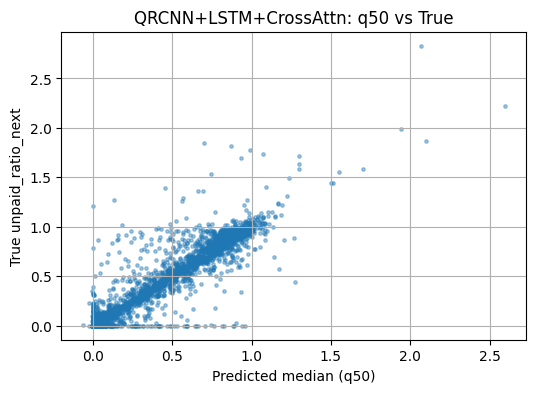

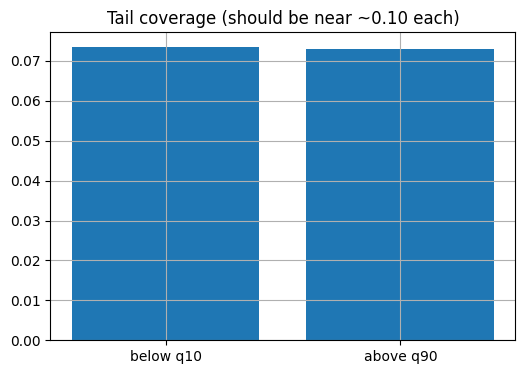

In [ ]:
# -------------------------------------------------------
# 11) 可視化（予測分位 vs 実測の分布）
# -------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.scatter(median, y_test, s=6, alpha=0.4)
plt.xlabel("Predicted median (q50)")
plt.ylabel("True unpaid_ratio_next")
plt.title("QRCNN+LSTM+CrossAttn: q50 vs True")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
res_lo = np.mean(y_test < lower)
res_hi = np.mean(y_test > upper)
plt.bar(['below q10','above q90'], [res_lo, res_hi])
plt.title('Tail coverage (should be near ~0.10 each)')
plt.grid(True)
plt.show()

# モデルの評価結果解釈

## QRCNN + LSTM + Cross-Attention モデル

Pinball Loss：全体的に低い（q0.1=0.0168, q0.5=0.0335, q0.9=0.0240） → 精度◎

PICP = 0.8536 → ちょっと高め（理想は0.8付近）。区間はやや広め。

Sharpness = 0.229 → そこそこ広い。

👉 精度が高く、カバーも余裕あり。
少し保守的（安全寄り）だが、業務利用では安心感あり。

## LSTM only

Pinball Loss：Aと同等かやや良い（中央値q0.5=0.0332と最小）。

PICP = 0.7861 → 理想の0.8に近い。

Sharpness = 0.185 → Aよりシャープ（区間が狭い）。

👉 最もバランスが良い。
適度にシャープで、カバー率もちょうど良い。過大でも過小でもない。

## Naive median (学習データ中央値を常に出す)

Pinball Loss：大きい（特にq0.5=0.1716 →中央値予測がズレている）。

PICP = 0.9043 → カバーしすぎ（ほぼ全員入る）。

Sharpness = 0.939 → 幅が広すぎる。

👉 区間が広すぎて「誰でも入っちゃう」状態。予測としては精度不足。
これは実務で使いにくい。

# ✅ 総合判断

最適：Bパターン
→ Pinball Loss最小、PICPが理想値に近く、Sharpnessも最もコンパクト。

次点：Aパターン
→ 精度は良いが、カバー率が高すぎ＝少し保守的。

不適：Cパターン
→ 幅広すぎて実質「予測になっていない」。

# 💡まとめ（実務的な選び方）

リスク管理で「過小評価したくない」場合 → Aパターン（安全側に倒す）。

リスクと精度のバランスを重視する場合 → Bパターンがベスト。

幅が広いCは使わない。